In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image

device = torch.device('cuda')

Random Erasing

In [2]:
import random

def random_erasing(image, probability=0.5, sl=0.02, sh=0.33, r1=0.3):
    """
    Randomly erases a rectangular region of the image.
    
    Args:
        image (PIL Image or Tensor): The input image.
        probability (float): Probability of applying random erasing.
        sl (float): Minimum proportion of erased area against the original area.
        sh (float): Maximum proportion of erased area against the original area.
        r1 (float): Aspect ratio of the erased area.
        
    Returns:
        The modified image with a random erasure applied.
    """
    if random.random() > probability:
        return image  # Do nothing if not applying random erasing

    # Get dimensions
    h, w = image.size if isinstance(image, Image.Image) else image.shape[1:3]
    area = h * w

    # Calculate the target area of the erasure
    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    # Calculate the height and width of the rectangle
    h_eraser = int(round((target_area * aspect_ratio) ** 0.5))
    w_eraser = int(round((target_area / aspect_ratio) ** 0.5))

    # Ensure the rectangle fits within the image
    if h_eraser > h or w_eraser > w:
        return image

    # Randomly choose the top left corner of the rectangle
    x = random.randint(0, w - w_eraser)
    y = random.randint(0, h - h_eraser)

    # Create a random erasing mask
    if isinstance(image, Image.Image):
        # Convert image to numpy array for erasing
        image = np.array(image)
    else:
        image = image.numpy()  # If tensor, convert to numpy

    image[y:y + h_eraser, x:x + w_eraser, :] = np.random.randint(0, 256, (h_eraser, w_eraser, 3), dtype=np.uint8)

    return image


Custom dataset class to label T-shirts (class 0) as normal, other classes as abnormal

In [3]:
class FashionMNISTCustom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom FashionMNIST dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
        """
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., T-shirts)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (T-shirt) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
class Cifar100Custom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom Cifar100 dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
            Parameters:
            - root: Path to the dataset.
            - train: Boolean indicating whether to load the training set (default is True).
            - transform: Transformations to be applied to the images (default is None).
            - normal_class: Class index to be labeled as normal (default is 0).
            - apply_erasing: Boolean indicating whether to apply random erasing (default is False).
        """
        self.dataset = datasets.CIFAR100(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., apple)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (apple) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1

        img = random_erasing(img)  # Apply random erasing

        if self.transform:
            img = self.transform(img)
        return img, label

SSAE Model Definition

In [5]:
class SSAE(nn.Module):
    def __init__(self):
        super(SSAE, self).__init__()
        # Encoder network: compresses image to 64 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 256),  # Input layer (32*32 image size)
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Decoder network: reconstructs the image from 64 dimensions
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 32*32*3),
            nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
        )

    def forward(self, x):
        # flatten the input image
        x = x.view(x.size(0), -1) # (BS, ch, w, h) -> (BS, ch*w*h)
        # Forward pass through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)

        # reshape the image again to (BS, ch, w, h)
        x = x.view(x.size(0), 3, 32, 32)

        return x
    
    def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):

        # Flatten the inputs and outputs for loss calculation
        inputs = inputs.view(inputs.size(0), -1)
        outputs = outputs.view(outputs.size(0), -1)

        # Standard reconstruction loss (Mean Squared Error)
        reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)

        # Separate normal and abnormal samples
        abnormal = labels > 0  # True for abnormal samples

        # Calculate additional abnormal loss
        abnormal_loss = reconstruction_loss[abnormal].mean() if abnormal.any() else torch.tensor(0.0)

        # Combine normal reconstruction loss and abnormal loss
        return reconstruction_loss.mean() + abnormal_loss

Data preparation

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                # Normalization according to CIFAR-100 mean and std
                                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
train_dataset = Cifar100Custom(train=True, transform=transform, normal_class=0)  # apple as normal
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = Cifar100Custom(train=False, transform=transform, normal_class=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


View samples from the dataset with labels (Normal: 0, Abnormal: 1)

In [7]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img, label = dataset[i]  # Get image and label
        
        # Convert tensor to numpy array for displaying
        if isinstance(img, torch.Tensor):
            # img = img.numpy().squeeze()  # Convert to numpy and squeeze to remove extra dimensions

             img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

        axes[i].imshow(img, cmap='gray')  # Display the image
        axes[i].set_title(f"Label: {'Normal' if label == 0 else 'Abnormal'}")
        axes[i].axis('off')
    
    plt.show()

Files already downloaded and verified
Total number of samples in the dataset: 50000


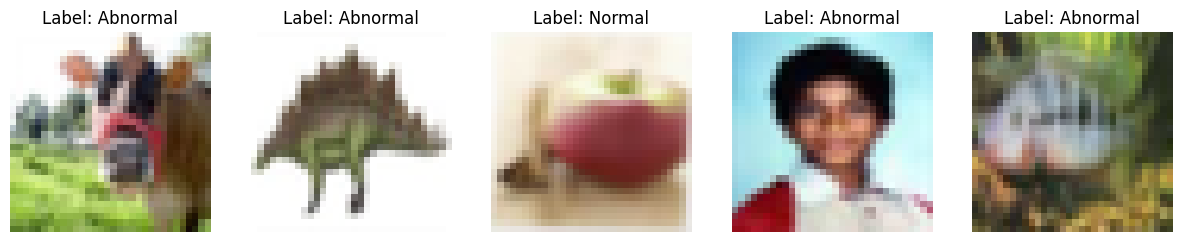

In [8]:
# Dataset with T-shirts (class 0) as normal and others as abnormal
train_dataset = Cifar100Custom(train=True, transform=transforms.ToTensor(), normal_class=0)

# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(train_dataset)}")

# Show a few samples with their labels
show_samples(train_dataset, num_samples=5)

In [9]:
# def visualize_random_erasing(dataset, num_samples=5):
#     fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
#     for i in range(num_samples):
#         img, label = dataset[i]
        
#         # Convert to numpy for visualization (CHW to HWC)
#         img = img.permute(1, 2, 0).numpy()
        
#         # Show original image
#         axes[0, i].imshow((img * 255).astype(np.uint8))  # Denormalize
#         axes[0, i].set_title(f"Original: {label}")
#         axes[0, i].axis('off')

#         # Apply random erasing
#         erased_img = random_erasing(img.copy())
        
#         # Show image with random erasing
#         axes[1, i].imshow(erased_img.astype(np.uint8))
#         axes[1, i].set_title("With Random Erasing")
#         axes[1, i].axis('off')

#     plt.show()

# # Visualize 5 random samples from the dataset
# visualize_random_erasing(train_dataset, num_samples=5)

In [10]:
model = SSAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
device = torch.device('cuda')

In [12]:
model.to(device)

SSAE(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

Training loop

In [13]:
# List to store loss values for plotting
loss_values = []
val_loss_values = []

# variable initialization to store the best validation loss
best_val_loss = float('inf')

for epoch in range(100):
    model.train()  # model in training mode
    total_loss = 0
    
    # tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10 (SSAE)")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        # Flatten the images for the autoencoder
        images = images.view(-1, 3*32*32)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = model.semi_supervised_loss(images, outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_loss:.4f}")
    
    
    # --- Validation loop ---
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            # Flatten the validation images
            val_images = val_images.view(-1, 3*32*32)
            
            # Forward pass
            val_outputs = model(val_images)
            
            # Calculate validation loss
            val_loss = model.semi_supervised_loss(val_images, val_outputs, val_labels)
            total_val_loss += val_loss.item()
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Print the average validation loss for the current epoch
    print(f"Epoch [{epoch+1}/10], Avg Validation Loss: {avg_val_loss:.4f}")
    
    # --- Model selection based on validation loss ---
    if avg_val_loss < best_val_loss and (epoch+1) % 5 == 0 :
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving the best model at epoch {epoch+1}.")
        torch.save(model.state_dict(), f'model_ssae_cifar100/best_model_epoch_{epoch+1}.pth')
    
    # Save the model after each epoch
    # torch.save(model.state_dict(), f'model_ssae_cifar100/ssae_cifar_epoch_{epoch+1}.pth')


Epoch 1/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 37.59it/s, loss=1.61]


Epoch [1/10], Avg Loss: 1.6486
Epoch [1/10], Avg Validation Loss: 1.5298


Epoch 2/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 39.10it/s, loss=1.5] 


Epoch [2/10], Avg Loss: 1.4819
Epoch [2/10], Avg Validation Loss: 1.4662


Epoch 3/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 37.45it/s, loss=1.41]


Epoch [3/10], Avg Loss: 1.4475
Epoch [3/10], Avg Validation Loss: 1.4481


Epoch 4/10 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.65it/s, loss=1.42]


Epoch [4/10], Avg Loss: 1.4239
Epoch [4/10], Avg Validation Loss: 1.4237


Epoch 5/10 (SSAE): 100%|██████████| 782/782 [00:54<00:00, 14.47it/s, loss=1.45]


Epoch [5/10], Avg Loss: 1.4087
Epoch [5/10], Avg Validation Loss: 1.4078
Validation loss improved. Saving the best model at epoch 5.


Epoch 6/10 (SSAE): 100%|██████████| 782/782 [00:57<00:00, 13.59it/s, loss=1.25]


Epoch [6/10], Avg Loss: 1.3979
Epoch [6/10], Avg Validation Loss: 1.4014


Epoch 7/10 (SSAE): 100%|██████████| 782/782 [01:06<00:00, 11.75it/s, loss=1.04]


Epoch [7/10], Avg Loss: 1.3904
Epoch [7/10], Avg Validation Loss: 1.3969


Epoch 8/10 (SSAE): 100%|██████████| 782/782 [01:07<00:00, 11.67it/s, loss=1.4] 


Epoch [8/10], Avg Loss: 1.3827
Epoch [8/10], Avg Validation Loss: 1.3873


Epoch 9/10 (SSAE): 100%|██████████| 782/782 [01:07<00:00, 11.59it/s, loss=1.54]


Epoch [9/10], Avg Loss: 1.3744
Epoch [9/10], Avg Validation Loss: 1.3802


Epoch 10/10 (SSAE): 100%|██████████| 782/782 [01:07<00:00, 11.65it/s, loss=1.53]


Epoch [10/10], Avg Loss: 1.3685
Epoch [10/10], Avg Validation Loss: 1.3686
Validation loss improved. Saving the best model at epoch 10.


Epoch 11/10 (SSAE): 100%|██████████| 782/782 [00:46<00:00, 16.74it/s, loss=1.49]


Epoch [11/10], Avg Loss: 1.3614
Epoch [11/10], Avg Validation Loss: 1.3681


Epoch 12/10 (SSAE): 100%|██████████| 782/782 [00:38<00:00, 20.16it/s, loss=1.64]


Epoch [12/10], Avg Loss: 1.3560
Epoch [12/10], Avg Validation Loss: 1.3622


Epoch 13/10 (SSAE): 100%|██████████| 782/782 [00:55<00:00, 14.03it/s, loss=1.22]


Epoch [13/10], Avg Loss: 1.3517
Epoch [13/10], Avg Validation Loss: 1.3572


Epoch 14/10 (SSAE): 100%|██████████| 782/782 [00:52<00:00, 14.98it/s, loss=1.57]


Epoch [14/10], Avg Loss: 1.3501
Epoch [14/10], Avg Validation Loss: 1.3544


Epoch 15/10 (SSAE): 100%|██████████| 782/782 [00:53<00:00, 14.54it/s, loss=1.16]


Epoch [15/10], Avg Loss: 1.3445
Epoch [15/10], Avg Validation Loss: 1.3497
Validation loss improved. Saving the best model at epoch 15.


Epoch 16/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.13it/s, loss=1.47]


Epoch [16/10], Avg Loss: 1.3425
Epoch [16/10], Avg Validation Loss: 1.3495


Epoch 17/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.91it/s, loss=1.29]


Epoch [17/10], Avg Loss: 1.3403
Epoch [17/10], Avg Validation Loss: 1.3454


Epoch 18/10 (SSAE): 100%|██████████| 782/782 [00:55<00:00, 14.19it/s, loss=1.54]


Epoch [18/10], Avg Loss: 1.3363
Epoch [18/10], Avg Validation Loss: 1.3425


Epoch 19/10 (SSAE): 100%|██████████| 782/782 [00:52<00:00, 14.80it/s, loss=1.46]


Epoch [19/10], Avg Loss: 1.3349
Epoch [19/10], Avg Validation Loss: 1.3424


Epoch 20/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.11it/s, loss=1.22]


Epoch [20/10], Avg Loss: 1.3333
Epoch [20/10], Avg Validation Loss: 1.3360
Validation loss improved. Saving the best model at epoch 20.


Epoch 21/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.06it/s, loss=1.26]


Epoch [21/10], Avg Loss: 1.3293
Epoch [21/10], Avg Validation Loss: 1.3375


Epoch 22/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.09it/s, loss=1.22]


Epoch [22/10], Avg Loss: 1.3280
Epoch [22/10], Avg Validation Loss: 1.3337


Epoch 23/10 (SSAE): 100%|██████████| 782/782 [00:52<00:00, 14.95it/s, loss=1.29]


Epoch [23/10], Avg Loss: 1.3248
Epoch [23/10], Avg Validation Loss: 1.3334


Epoch 24/10 (SSAE): 100%|██████████| 782/782 [00:52<00:00, 14.88it/s, loss=1.16]


Epoch [24/10], Avg Loss: 1.3236
Epoch [24/10], Avg Validation Loss: 1.3330


Epoch 25/10 (SSAE): 100%|██████████| 782/782 [00:59<00:00, 13.16it/s, loss=1.42]


Epoch [25/10], Avg Loss: 1.3227
Epoch [25/10], Avg Validation Loss: 1.3280
Validation loss improved. Saving the best model at epoch 25.


Epoch 26/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.11it/s, loss=0.934]


Epoch [26/10], Avg Loss: 1.3186
Epoch [26/10], Avg Validation Loss: 1.3250


Epoch 27/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.33it/s, loss=1.43]


Epoch [27/10], Avg Loss: 1.3165
Epoch [27/10], Avg Validation Loss: 1.3217


Epoch 28/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 16.05it/s, loss=0.998]


Epoch [28/10], Avg Loss: 1.3159
Epoch [28/10], Avg Validation Loss: 1.3211


Epoch 29/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.74it/s, loss=1.5] 


Epoch [29/10], Avg Loss: 1.3168
Epoch [29/10], Avg Validation Loss: 1.3218


Epoch 30/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.84it/s, loss=1.48]


Epoch [30/10], Avg Loss: 1.3150
Epoch [30/10], Avg Validation Loss: 1.3210
Validation loss improved. Saving the best model at epoch 30.


Epoch 31/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 16.02it/s, loss=1.51]


Epoch [31/10], Avg Loss: 1.3136
Epoch [31/10], Avg Validation Loss: 1.3174


Epoch 32/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 15.96it/s, loss=1.45]


Epoch [32/10], Avg Loss: 1.3125
Epoch [32/10], Avg Validation Loss: 1.3211


Epoch 33/10 (SSAE): 100%|██████████| 782/782 [00:50<00:00, 15.63it/s, loss=1.19]


Epoch [33/10], Avg Loss: 1.3113
Epoch [33/10], Avg Validation Loss: 1.3167


Epoch 34/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.32it/s, loss=1.39]


Epoch [34/10], Avg Loss: 1.3097
Epoch [34/10], Avg Validation Loss: 1.3147


Epoch 35/10 (SSAE): 100%|██████████| 782/782 [00:46<00:00, 16.85it/s, loss=1.07]


Epoch [35/10], Avg Loss: 1.3099
Epoch [35/10], Avg Validation Loss: 1.3132
Validation loss improved. Saving the best model at epoch 35.


Epoch 36/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.33it/s, loss=1.27]


Epoch [36/10], Avg Loss: 1.3074
Epoch [36/10], Avg Validation Loss: 1.3177


Epoch 37/10 (SSAE): 100%|██████████| 782/782 [00:41<00:00, 18.72it/s, loss=1.21]


Epoch [37/10], Avg Loss: 1.3066
Epoch [37/10], Avg Validation Loss: 1.3151


Epoch 38/10 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.34it/s, loss=1.2] 


Epoch [38/10], Avg Loss: 1.3054
Epoch [38/10], Avg Validation Loss: 1.3103


Epoch 39/10 (SSAE): 100%|██████████| 782/782 [00:23<00:00, 33.17it/s, loss=1.03]


Epoch [39/10], Avg Loss: 1.3040
Epoch [39/10], Avg Validation Loss: 1.3148


Epoch 40/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.15it/s, loss=1.05]


Epoch [40/10], Avg Loss: 1.3028
Epoch [40/10], Avg Validation Loss: 1.3097
Validation loss improved. Saving the best model at epoch 40.


Epoch 41/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.97it/s, loss=1.16]


Epoch [41/10], Avg Loss: 1.3022
Epoch [41/10], Avg Validation Loss: 1.3080


Epoch 42/10 (SSAE): 100%|██████████| 782/782 [00:24<00:00, 32.47it/s, loss=1.09] 


Epoch [42/10], Avg Loss: 1.3008
Epoch [42/10], Avg Validation Loss: 1.3069


Epoch 43/10 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.34it/s, loss=1.06]


Epoch [43/10], Avg Loss: 1.3000
Epoch [43/10], Avg Validation Loss: 1.3083


Epoch 44/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.71it/s, loss=1.46] 


Epoch [44/10], Avg Loss: 1.3004
Epoch [44/10], Avg Validation Loss: 1.3030


Epoch 45/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 35.65it/s, loss=1.07]


Epoch [45/10], Avg Loss: 1.2976
Epoch [45/10], Avg Validation Loss: 1.3058
Validation loss improved. Saving the best model at epoch 45.


Epoch 46/10 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.60it/s, loss=1.11]


Epoch [46/10], Avg Loss: 1.2985
Epoch [46/10], Avg Validation Loss: 1.3030


Epoch 47/10 (SSAE): 100%|██████████| 782/782 [00:57<00:00, 13.52it/s, loss=1.42]


Epoch [47/10], Avg Loss: 1.2979
Epoch [47/10], Avg Validation Loss: 1.3028


Epoch 48/10 (SSAE): 100%|██████████| 782/782 [00:55<00:00, 14.15it/s, loss=1.82]


Epoch [48/10], Avg Loss: 1.2965
Epoch [48/10], Avg Validation Loss: 1.3030


Epoch 49/10 (SSAE): 100%|██████████| 782/782 [00:52<00:00, 15.03it/s, loss=1.16]


Epoch [49/10], Avg Loss: 1.2955
Epoch [49/10], Avg Validation Loss: 1.3015


Epoch 50/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.40it/s, loss=1.39]


Epoch [50/10], Avg Loss: 1.2946
Epoch [50/10], Avg Validation Loss: 1.3009
Validation loss improved. Saving the best model at epoch 50.


Epoch 51/10 (SSAE): 100%|██████████| 782/782 [00:46<00:00, 16.69it/s, loss=1.07]


Epoch [51/10], Avg Loss: 1.2928
Epoch [51/10], Avg Validation Loss: 1.2998


Epoch 52/10 (SSAE): 100%|██████████| 782/782 [00:46<00:00, 16.98it/s, loss=1.15]


Epoch [52/10], Avg Loss: 1.2927
Epoch [52/10], Avg Validation Loss: 1.2963


Epoch 53/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 16.25it/s, loss=1.21]


Epoch [53/10], Avg Loss: 1.2916
Epoch [53/10], Avg Validation Loss: 1.3010


Epoch 54/10 (SSAE): 100%|██████████| 782/782 [00:46<00:00, 16.64it/s, loss=1.25]


Epoch [54/10], Avg Loss: 1.2924
Epoch [54/10], Avg Validation Loss: 1.3009


Epoch 55/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 16.08it/s, loss=1.51]


Epoch [55/10], Avg Loss: 1.2911
Epoch [55/10], Avg Validation Loss: 1.2976
Validation loss improved. Saving the best model at epoch 55.


Epoch 56/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.94it/s, loss=1.46]


Epoch [56/10], Avg Loss: 1.2905
Epoch [56/10], Avg Validation Loss: 1.2947


Epoch 57/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.37it/s, loss=1.45]


Epoch [57/10], Avg Loss: 1.2896
Epoch [57/10], Avg Validation Loss: 1.2936


Epoch 58/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.45it/s, loss=1.18]


Epoch [58/10], Avg Loss: 1.2900
Epoch [58/10], Avg Validation Loss: 1.2972


Epoch 59/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.72it/s, loss=1.45]


Epoch [59/10], Avg Loss: 1.2883
Epoch [59/10], Avg Validation Loss: 1.2950


Epoch 60/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.40it/s, loss=1.23] 


Epoch [60/10], Avg Loss: 1.2879
Epoch [60/10], Avg Validation Loss: 1.2940
Validation loss improved. Saving the best model at epoch 60.


Epoch 61/10 (SSAE): 100%|██████████| 782/782 [00:47<00:00, 16.31it/s, loss=1.17]


Epoch [61/10], Avg Loss: 1.2878
Epoch [61/10], Avg Validation Loss: 1.2919


Epoch 62/10 (SSAE): 100%|██████████| 782/782 [00:51<00:00, 15.13it/s, loss=1.31] 


Epoch [62/10], Avg Loss: 1.2876
Epoch [62/10], Avg Validation Loss: 1.2934


Epoch 63/10 (SSAE): 100%|██████████| 782/782 [00:49<00:00, 15.95it/s, loss=1.36]


Epoch [63/10], Avg Loss: 1.2863
Epoch [63/10], Avg Validation Loss: 1.2900


Epoch 64/10 (SSAE): 100%|██████████| 782/782 [00:50<00:00, 15.58it/s, loss=1.21]


Epoch [64/10], Avg Loss: 1.2859
Epoch [64/10], Avg Validation Loss: 1.2884


Epoch 65/10 (SSAE): 100%|██████████| 782/782 [00:48<00:00, 16.12it/s, loss=1.39]


Epoch [65/10], Avg Loss: 1.2863
Epoch [65/10], Avg Validation Loss: 1.2898
Validation loss improved. Saving the best model at epoch 65.


Epoch 66/10 (SSAE): 100%|██████████| 782/782 [00:38<00:00, 20.30it/s, loss=1.61]


Epoch [66/10], Avg Loss: 1.2858
Epoch [66/10], Avg Validation Loss: 1.2907


Epoch 67/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.18it/s, loss=1.22]


Epoch [67/10], Avg Loss: 1.2858
Epoch [67/10], Avg Validation Loss: 1.2911


Epoch 68/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.77it/s, loss=1.15]


Epoch [68/10], Avg Loss: 1.2870
Epoch [68/10], Avg Validation Loss: 1.2928


Epoch 69/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.12it/s, loss=1.22] 


Epoch [69/10], Avg Loss: 1.2832
Epoch [69/10], Avg Validation Loss: 1.2856


Epoch 70/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.02it/s, loss=1.32]


Epoch [70/10], Avg Loss: 1.2844
Epoch [70/10], Avg Validation Loss: 1.2914


Epoch 71/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 35.20it/s, loss=1.22]


Epoch [71/10], Avg Loss: 1.2847
Epoch [71/10], Avg Validation Loss: 1.2913


Epoch 72/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 37.08it/s, loss=1.28]


Epoch [72/10], Avg Loss: 1.2824
Epoch [72/10], Avg Validation Loss: 1.2886


Epoch 73/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.71it/s, loss=1.17]


Epoch [73/10], Avg Loss: 1.2815
Epoch [73/10], Avg Validation Loss: 1.2843


Epoch 74/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.42it/s, loss=1.14] 


Epoch [74/10], Avg Loss: 1.2816
Epoch [74/10], Avg Validation Loss: 1.2899


Epoch 75/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 40.99it/s, loss=1.21]


Epoch [75/10], Avg Loss: 1.2820
Epoch [75/10], Avg Validation Loss: 1.2921


Epoch 76/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 38.74it/s, loss=1.45]


Epoch [76/10], Avg Loss: 1.2813
Epoch [76/10], Avg Validation Loss: 1.2876


Epoch 77/10 (SSAE): 100%|██████████| 782/782 [00:36<00:00, 21.42it/s, loss=1.29]


Epoch [77/10], Avg Loss: 1.2807
Epoch [77/10], Avg Validation Loss: 1.2874


Epoch 78/10 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.41it/s, loss=1.38]


Epoch [78/10], Avg Loss: 1.2810
Epoch [78/10], Avg Validation Loss: 1.2866


Epoch 79/10 (SSAE): 100%|██████████| 782/782 [00:23<00:00, 32.98it/s, loss=1.19]


Epoch [79/10], Avg Loss: 1.2790
Epoch [79/10], Avg Validation Loss: 1.2889


Epoch 80/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 37.28it/s, loss=1.19]


Epoch [80/10], Avg Loss: 1.2792
Epoch [80/10], Avg Validation Loss: 1.2849
Validation loss improved. Saving the best model at epoch 80.


Epoch 81/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.63it/s, loss=1.45]


Epoch [81/10], Avg Loss: 1.2806
Epoch [81/10], Avg Validation Loss: 1.2859


Epoch 82/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.43it/s, loss=1.2] 


Epoch [82/10], Avg Loss: 1.2793
Epoch [82/10], Avg Validation Loss: 1.2876


Epoch 83/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.51it/s, loss=1.11] 


Epoch [83/10], Avg Loss: 1.2784
Epoch [83/10], Avg Validation Loss: 1.2827


Epoch 84/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 37.70it/s, loss=1.37]


Epoch [84/10], Avg Loss: 1.2789
Epoch [84/10], Avg Validation Loss: 1.2862


Epoch 85/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 40.17it/s, loss=0.933]


Epoch [85/10], Avg Loss: 1.2774
Epoch [85/10], Avg Validation Loss: 1.2834
Validation loss improved. Saving the best model at epoch 85.


Epoch 86/10 (SSAE): 100%|██████████| 782/782 [00:20<00:00, 38.94it/s, loss=1.49]


Epoch [86/10], Avg Loss: 1.2782
Epoch [86/10], Avg Validation Loss: 1.2857


Epoch 87/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 40.47it/s, loss=1.09]


Epoch [87/10], Avg Loss: 1.2776
Epoch [87/10], Avg Validation Loss: 1.2840


Epoch 88/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.75it/s, loss=1.6] 


Epoch [88/10], Avg Loss: 1.2781
Epoch [88/10], Avg Validation Loss: 1.2815


Epoch 89/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.10it/s, loss=1.16]


Epoch [89/10], Avg Loss: 1.2780
Epoch [89/10], Avg Validation Loss: 1.2844


Epoch 90/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 40.72it/s, loss=1.24]


Epoch [90/10], Avg Loss: 1.2772
Epoch [90/10], Avg Validation Loss: 1.2853


Epoch 91/10 (SSAE): 100%|██████████| 782/782 [00:18<00:00, 41.58it/s, loss=1.35]


Epoch [91/10], Avg Loss: 1.2765
Epoch [91/10], Avg Validation Loss: 1.2866


Epoch 92/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.93it/s, loss=1.09]


Epoch [92/10], Avg Loss: 1.2761
Epoch [92/10], Avg Validation Loss: 1.2877


Epoch 93/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 37.04it/s, loss=1.11]


Epoch [93/10], Avg Loss: 1.2755
Epoch [93/10], Avg Validation Loss: 1.2847


Epoch 94/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 37.07it/s, loss=1.08]


Epoch [94/10], Avg Loss: 1.2757
Epoch [94/10], Avg Validation Loss: 1.2813


Epoch 95/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.40it/s, loss=1.16]


Epoch [95/10], Avg Loss: 1.2765
Epoch [95/10], Avg Validation Loss: 1.2836


Epoch 96/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 36.38it/s, loss=1.04]


Epoch [96/10], Avg Loss: 1.2754
Epoch [96/10], Avg Validation Loss: 1.2801


Epoch 97/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 40.71it/s, loss=1.03]


Epoch [97/10], Avg Loss: 1.2760
Epoch [97/10], Avg Validation Loss: 1.2828


Epoch 98/10 (SSAE): 100%|██████████| 782/782 [00:19<00:00, 39.60it/s, loss=1.21]


Epoch [98/10], Avg Loss: 1.2748
Epoch [98/10], Avg Validation Loss: 1.2819


Epoch 99/10 (SSAE): 100%|██████████| 782/782 [00:21<00:00, 35.96it/s, loss=1.21]


Epoch [99/10], Avg Loss: 1.2749
Epoch [99/10], Avg Validation Loss: 1.2830


Epoch 100/10 (SSAE): 100%|██████████| 782/782 [00:22<00:00, 34.47it/s, loss=1.33] 


Epoch [100/10], Avg Loss: 1.2734
Epoch [100/10], Avg Validation Loss: 1.2823
Validation loss improved. Saving the best model at epoch 100.


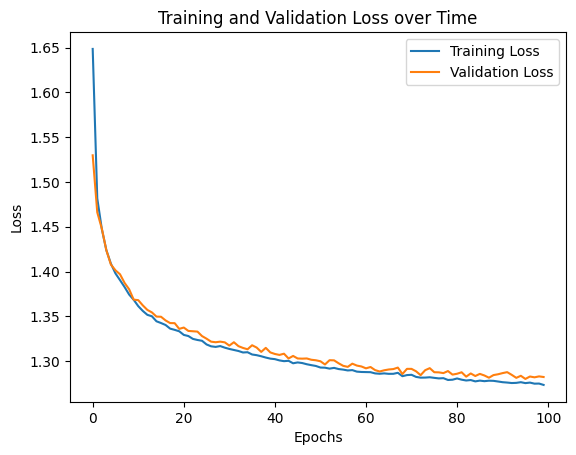

In [14]:
# Plot both training and validation losses
plt.plot(loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

Checking Model's Performance and Visualizing Reconstruction

In [57]:
def visualize_reconstruction(model, dataset, num_samples=10, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    model.load_state_dict(torch.load('model_ssae_cifar100/best_model_epoch_100.pth'))
    model.eval()

    model.to(device)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        img, label = dataset[i]
        # img, label = img.to(device), label.to(device)
        img = img.view(1, -1).to(device)  # Flatten image
        
        # Forward pass to get the reconstruction
        with torch.no_grad():
            img = img.to(device)
            reconstructed_img = model(img)

        # Reshape images back to 28x28 for visualization
        # img = img.view(28, 28)
        # reconstructed_img = reconstructed_img.view(28, 28)
        
        # Reshape images back to 32x32 with 3 channels for visualization
        img = img.view(3, 32, 32).permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C) format
        reconstructed_img = reconstructed_img.view(3, 32, 32).permute(1, 2, 0).cpu().numpy()  # Reshape and permute back

        
        # Plot original image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original: {'Normal' if label == 0 else 'Abnormal'}")
        axes[0, i].axis('off')
        
        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_img, cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

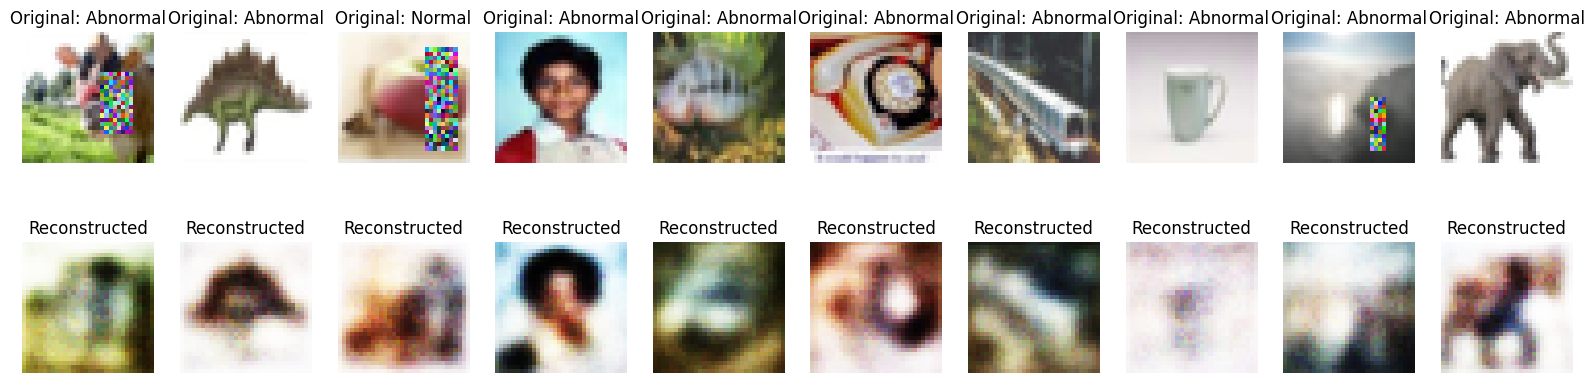

In [58]:
visualize_reconstruction(model, train_dataset, device=device)